# WALLABY admin notebook

Template Jupyter Notebook to provide the WALLABY project team with functions to manage the WALLABY database. Intended for the manual inspection step of source finding where detections are checked visually before being added to the catalogue. The notebook provides code snippets for the following:

- Setup
- Auto-resolution of detections (TBA - it might be easiest to use SoFiAX for this)
- Manually resolve conflicts
    - Two or more detections with similar location but different properties (pick either or randomly), show moment 0 map and spectrum
    - Conflicts with existing catalogue data (retain old name for new detection - add reference to the existing source if properties differ significantly)
    - Cross-correlation to search within the radius of a given source for two detections that are components of a source. Visualise to see if that is the case. Will need to run `sofia` again to merge the components.
- Confirm sources
- Catalogue completeness check
- Tag all sources in catalogue

# Setup

There are three steps involved in setting up the notebook. They are:

- Provide database credentials
- Initialise Django
- Select Run

## Database credentials

Since this is an admin notebook, the admin will have to provide the password with admin access to the database. Without this password the user will only be granted read-only access to the database and will not be able to update the contents of the tables.

Update the `admin_password` variable here. You will need it to update the database from within the notebook.

In [1]:
# TODO(user): update password field here

admin_password = "@2faqkADMWVU@qFpJA"
user_password = "LKaRsQrNtXZ7vN8L*6"

## Initialise Django

The following cells must be run first. They are used to import `django`, set up a connection to the database and import the Django models. Once these cells are run, you are able to use the Django model objects for access to the database.

In [2]:
# Essential Python libraries for using the ORM

import sys
import os
import django

In [3]:
# Database access environment variables

os.environ["DJANGO_SECRET_KEY"] = "-=(gyah-@e$-ymbz02mhwu6461zv&1&8uojya413ylk!#bwa-l"
os.environ["DJANGO_SETTINGS_MODULE"] = "api.settings"
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "True"
os.environ["DATABASE_HOST"] = "146.118.67.204"
os.environ["DATABASE_NAME"] = "wallabydb"
os.environ["DATABASE_USER"] = "wallaby_user" if admin_password is None else "admin"
os.environ["DATABASE_PASSWORD"] = user_password if admin_password is None else admin_password

In [4]:
# Connect with SoFiAX_services Django ORM

sys.path.append('/mnt/shared/wallaby/apps/SoFiAX_services/api/')
django.setup()

In [5]:
# Import models

from tables.models import Run, Instance, Detection, Product, Source, SourceDetection

## Select Run

The second step once you enter the credentails for write access to the database is to select the Run for which you would like to select sources.

In [6]:
Run.objects.all()

<QuerySet [<Run: Hydra_DR1>, <Run: Hydra_DR2>, <Run: NGC4636_DR1>, <Run: Norma_DR1>, <Run: NGC5044_4>, <Run: NGC4808>]>

In [7]:
# TODO(user): select Run name

run_name = "NGC4808"

# Auto-resolve detections (?)

# Plotting

Here we will include some functions for producing plots of the products of a given detection. These will be used in both following sections.

In [8]:
# plotting libraries

import io
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval
from astroquery.skyview import SkyView
from astropy.utils.data import clear_download_cache

In [9]:
clear_download_cache()

In [35]:
# Add summary plot output product for certain detections

def add_summary_plot(detection):
    # Plot figure size    
    interval = PercentileInterval(95.0)
    interval2 = PercentileInterval(90.0)
    plt.rcParams["figure.figsize"] = (12,12)
    
    # Retrieve products from database
    products = Product.objects.get(detection=detection)
    
    # Open moment 0 image
    with io.BytesIO() as buf:
        buf.write(products.mom0)
        buf.seek(0)
        hdu_mom0 = fits.open(buf)[0]
        wcs = WCS(hdu_mom0.header)
        mom0 = hdu_mom0.data

    # Open moment 1 image
    with io.BytesIO() as buf:
        buf.write(products.mom1)
        buf.seek(0)
        hdu_mom1 = fits.open(buf)[0]
        mom1 = hdu_mom1.data

    # Spectrum
    with io.BytesIO() as buf:
        buf.write(b''.join(products.spec))
        buf.seek(0)
        spectrum = np.loadtxt(buf, dtype="float", comments="#", unpack=True)

    # Extract coordinate information
    nx = hdu_mom0.header["NAXIS1"]
    ny = hdu_mom0.header["NAXIS2"]
    clon, clat = wcs.all_pix2world(nx/2, ny/2, 0)
    tmp1, tmp3 = wcs.all_pix2world(0, ny/2, 0)
    tmp2, tmp4 = wcs.all_pix2world(nx, ny/2, 0)
    width = np.rad2deg(math.acos(math.sin(np.deg2rad(tmp3)) * math.sin(np.deg2rad(tmp4)) + math.cos(np.deg2rad(tmp3)) * math.cos(np.deg2rad(tmp4)) * math.cos(np.deg2rad(tmp1 - tmp2))))
    tmp1, tmp3 = wcs.all_pix2world(nx/2, 0, 0)
    tmp2, tmp4 = wcs.all_pix2world(nx/2, ny, 0)
    height = np.rad2deg(math.acos(math.sin(np.deg2rad(tmp3)) * math.sin(np.deg2rad(tmp4)) + math.cos(np.deg2rad(tmp3)) * math.cos(np.deg2rad(tmp4)) * math.cos(np.deg2rad(tmp1 - tmp2))))

    # Download DSS image from SkyView
    hdu_opt = SkyView.get_images(
        position="{}d {}d".format(clon, clat),
        survey="DSS",
        coordinates="J2000",
        projection="Tan",
        width=width*u.deg,
        height=height*u.deg,
        cache=None
    )[0][0]
    wcs_opt = WCS(hdu_opt.header)

    # Plot moment 0
    ax2 = plt.subplot(2, 2, 1, projection=wcs);
    ax2.imshow(mom0, origin="lower");
    ax2.grid(color="grey", ls="solid");
    ax2.set_xlabel("Right ascension (J2000)");
    ax2.set_ylabel("Declination (J2000)");
    ax2.tick_params(axis="x", which="both", left=False, right=False);
    ax2.tick_params(axis="y", which="both", top=False, bottom=False);
    ax2.set_title("moment 0");

    # Add beam size     
    e = Ellipse((5, 5), 5, 5, 0, edgecolor='peru', facecolor='peru');
    ax2.add_patch(e);

    # Plot DSS image with HI contours
    bmin, bmax = interval2.get_limits(hdu_opt.data);
    ax = plt.subplot(2, 2, 2, projection=wcs_opt);
    ax.imshow(hdu_opt.data, origin="lower");
    ax.contour(hdu_mom0.data, transform=ax.get_transform(wcs), levels=np.logspace(2.0, 5.0, 10), colors="lightgrey", alpha=1.0);
    ax.grid(color="grey", ls="solid");
    ax.set_xlabel("Right ascension (J2000)");
    ax.set_ylabel("Declination (J2000)");
    ax.tick_params(axis="x", which="both", left=False, right=False);
    ax.tick_params(axis="y", which="both", top=False, bottom=False);
    ax.set_title("DSS + moment 0");

    # Plot moment 1
    bmin, bmax = interval.get_limits(mom1);
    ax3 = plt.subplot(2, 2, 3, projection=wcs);
    ax3.imshow(hdu_mom1.data, origin="lower", vmin=bmin, vmax=bmax, cmap=plt.get_cmap("gist_rainbow"));
    ax3.grid(color="grey", ls="solid");
    ax3.set_xlabel("Right ascension (J2000)");
    ax3.set_ylabel("Declination (J2000)");
    ax3.tick_params(axis="x", which="both", left=False, right=False);
    ax3.tick_params(axis="y", which="both", top=False, bottom=False);
    ax3.set_title("moment 1");

    # Plot spectrum
    xaxis = spectrum[1] / 1e+6;
    data  = 1000.0 * np.nan_to_num(spectrum[2]);
    xmin = np.nanmin(xaxis);
    xmax = np.nanmax(xaxis);
    ymin = np.nanmin(data);
    ymax = np.nanmax(data);
    ymin -= 0.1 * (ymax - ymin);
    ymax += 0.1 * (ymax - ymin);
    ax4 = plt.subplot(2, 2, 4);
    ax4.step(xaxis, data, where="mid", color="royalblue");
    ax4.set_xlabel("Frequency (MHz)");
    ax4.set_ylabel("Flux density (mJy)");
    ax4.set_title("spectrum");
    ax4.grid(True);
    ax4.set_xlim([xmin, xmax]);
    ax4.set_ylim([ymin, ymax]);

    plt.suptitle(detection.name.replace("_", " ").replace("-", "−"), fontsize=16);

    # write to products
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt_bytes = buf.read()
    products.summary = plt_bytes
    products.save()
    buf.close()
    plt.close()

In [36]:
# plotting function for summary plot

import matplotlib.image as mpimg

def plot_summary(detection):
    products = Product.objects.get(detection=detection)
    with io.BytesIO() as buf:
        buf.write(b''.join(products.summary))
        buf.seek(0)
        img = mpimg.imread(buf, format='png')

    plt.rcParams["figure.figsize"] = (12,12)
    plt.imshow(img)
    plt.show()

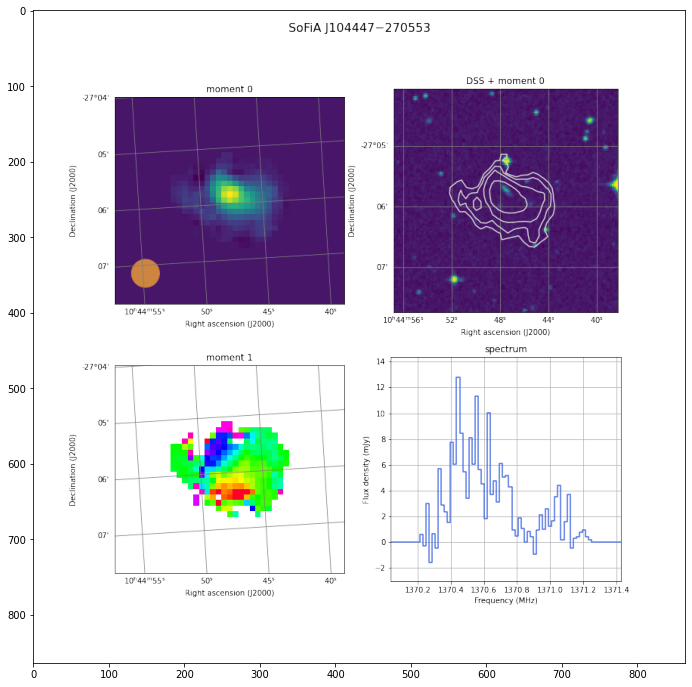

In [37]:
%matplotlib inline

plot_summary(Detection.objects.get(id=1))

# Confirm sources

This section of the notebook allows you to quickly add detections to the sources table after a quick visual inspection. The assumption that we make here is that for a given Run, any detections remaining in the database without a reference to a source at this stage are likely source candidates given they have passed the auto-resolution filter of `SoFiAX` and are not marked to be manually resolved. Here we allow users to quickly verify these detections are in fact sources, and quickly add the foreign key reference to the source table.

**NOTE**: While the DSS image is being downloaded the plot will disappear. This is normal behaviour don't stress :)

In [38]:
# Find detections without a source counterpart

detections_to_confirm = Detection.objects\
    .filter(run_id=Run.objects.get(name=run_name).id)\
    .filter(n_pix__gte=300)\
    .filter(rel__gte=0.7)\
    .filter(rel__lt=2.0)\
    .exclude(id__in=[d.detection_id for d in SourceDetection.objects.all()])

len(detections_to_confirm)

611

In [39]:
# Create summary plots for all detections

for d in detections_to_confirm:
    if Product.objects.get(detection=d).summary is None:
        add_summary_plot(d)

In [40]:
%%capture

!pip install ipywidgets==7.4.0
!pip install jupyter

In [41]:
# Interactive comparison plot

from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import HBox
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

detections_to_confirm_ids = [d.id for d in detections_to_confirm]
initial_index = 0

plot = widgets.Output()
with plot:
    plot_summary(Detection.objects.get(id=detections_to_confirm_ids[initial_index]))

previous_button = widgets.Button(
    value=False,
    description='< Previous',
    disabled=False,
    button_style='',
    tooltip='Go to previous detection'
)
next_button = widgets.Button(
    value=False,
    description='Next >',
    disabled=False,
    button_style='',
    tooltip='Go to next detection'
)
add_button = widgets.Button(
    value=False,
    description='Insert',
    disabled=False,
    button_style='success',
    tooltip='Add detection to source table'
)
reject_button = widgets.Button(
    value=False,
    description='Delete',
    disabled=False,
    button_style='danger',
    tooltip='Delete detection from table'
)
detection_slider = widgets.IntSlider(
    value=initial_index,
    description='Progress:',
    disabled=True,
    min=0,
    max=len(detections_to_confirm_ids)
)

def add_button_callback(button):
    detection = Detection.objects.get(id=detections_to_confirm_ids[detection_slider.value])
    wallaby_name = detection.name.replace(' ', '_').replace('SoFiA', 'WALLABY')
    source = Source.objects.create(name=wallaby_name)
    s2d = SourceDetection.objects.create(source_id=source.id, detection_id=detection.id)
    
    detections_to_confirm_ids.pop(detection_slider.value)
    with plot:
        clear_output()
        plot_summary(Detection.objects.get(id=detections_to_confirm_ids[detection_slider.value]))
    display(plot, detection_slider, buttons)

def reject_button_callback(button):
    detection = Detection.objects.get(id=detections_to_confirm_ids[detection_slider.value])
    detection.delete()
    
    detections_to_confirm_ids.pop(detection_slider.value)
    with plot:
        clear_output()
        plot_summary(Detection.objects.get(id=detections_to_confirm_ids[detection_slider.value]))
    display(plot, detection_slider, buttons)
    
def next_button_callback(button):
    if detection_slider.value < len(detections_to_confirm_ids):
        detection_slider.value += 1
        with plot:
            clear_output()
            plot_summary(Detection.objects.get(id=detections_to_confirm_ids[detection_slider.value]))
        display(plot, detection_slider, buttons)
        
def previous_button_callback(button):
    if detection_slider.value != 0:
        detection_slider.value -= 1
        with plot:
            clear_output()
            plot_summary(Detection.objects.get(id=detections_to_confirm_ids[detection_slider.value]))
        display(plot, detection_slider, buttons)
    
add_button.on_click(add_button_callback)
reject_button.on_click(reject_button_callback)
next_button.on_click(next_button_callback)
previous_button.on_click(previous_button_callback)
buttons = HBox([previous_button, add_button, reject_button, next_button, detection_slider])

In [42]:
# Run interactive plot inspection

display(plot, buttons)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 864x864 with 1 Axes>', 'i…